# Laboratorium 1


### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
import json as js
import math
import random
from scipy.stats import linregress


TEN_TO_FIVE = int(math.pow(10, 5))
TEN_TO_FOURTEEN = int(math.pow(10, 14))

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker
        
class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, [mcolors.to_rgba(self.color)] * len(self.lines))
        else:
            return mcoll.LineCollection(self.lines)

class Plot:
    def __init__(self, points=[], lines=[], json = None):
        if json is None:
            self.points = points
            self.lines = lines
        else:
            self.points = [PointsCollection(pointsCol) for pointsCol in js.loads(json)["points"]]
            self.lines = [LinesCollection(linesCol) for linesCol in js.loads(json)["lines"]]
            
    def draw(self):
        plt.close()
        ax = plt.axes()
        for collection in self.points:
            if collection.points.size > 0:
                ax.scatter(*zip(*collection.points), c=collection.color, marker=collection.marker)
        for collection in self.lines:
            ax.add_collection(collection.get_collection())
        ax.autoscale()
        plt.draw()
        
    def toJSON(self):
        return js.dumps({"points": [pointCol.points.tolist() for pointCol in self.points], 
                          "lines":[linesCol.lines for linesCol in self.lines]})

### Przykład użycia

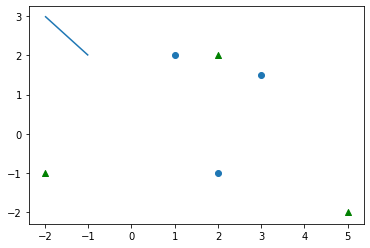

In [3]:
%matplotlib inline

plot = Plot([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
             PointsCollection([(5, -2), (2, 2), (-2, -1)], color = 'green', marker = "^")], 
            [LinesCollection([[(-1,2),(-2,3)]])])
plot.draw()


### Rozwiązanie

#### Funkcje słóżące do generowania list losowych punktów
Funkcja losująca punkty została zaprojektowana w taki sposób, aby generator punktu losowego można było przekazać jako arguemnt. Pozwala to na implementację różnych generatorów punktu spełniających odpowiednia kowencję tj. przyjmujących dwa argumenty typu krotka na wejście. Zaimplementowałem następujące generatory punktu:
1. generator punktu losowego, jako argumenty podajemy zakres współżędnej x oraz zakres współżędnej y
2. generator punktu losowego na okręgu, jako argument podajemy zakres kąta(na jakim wycinku koła chcemy losowapunktu),    oraz zakres promienia w jakim maja być punkty od punktu (0,0)
3. generator punktu losowego na lini, jako argument podajmey krotkę skądająca się z współczynnika kierunkowego prostej oraz jej przesunięcia, oraz krotkę wyrażającą zakres w jakim maja znaleźć się obie współżędne losowanego punktu.

In [4]:
def generate_random_point(range_a, range_b):
    return random.uniform(range_a[0], range_a[1]),random.uniform(range_b[0], range_b[1])

def generate_point_on_circle(angle_range, radius_range):
    angle = random.uniform(angle_range[0], angle_range[1])
    radius = random.uniform(radius_range[0], radius_range[1])
    return math.cos(angle)*radius, math.sin(angle)*radius

def generate_point_on_line(slope_intercept, range_x_y):
    slope = slope_intercept[0]
    intercept = slope_intercept[1]
    A = range_x_y[0]
    B = range_x_y[1]
    if slope < 0:
        new_A = (B-intercept)/slope
        new_B = (A-intercept)/slope
    if slope > 0:
        new_A = (A-intercept)/slope
        new_B = (B-intercept)/slope
    
    if new_A > A:
        A = new_A
    if new_B < B:
        B = new_B
    x = random.uniform(A, B)
    return x, slope*x+intercept

def generate_array_of_random_points(n, range_x, range_y=None, generator=generate_random_point):
    points = []
    if range_y is None:
        range_y = range_x
    for i in range(0, n):
        points.append(generator(range_x, range_y))
    return points


#### a) 10^5 losowych punktów o współrzędnych z przedziału [-1000, 1000]

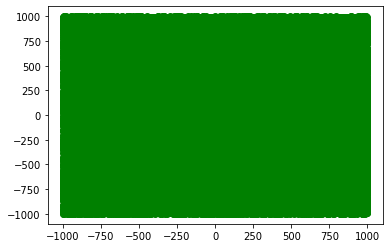

In [5]:
%matplotlib inline

points_1 = generate_array_of_random_points(TEN_TO_FIVE,(-1000,1000))
plot1 = Plot([PointsCollection(points_1, color="green")])
plot1.draw()

#### b) 10^5 losowych punktów o współrzędnych z przedziału [-10^14, 10^14], 

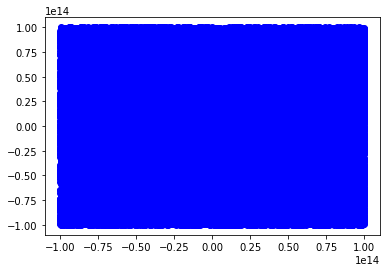

In [6]:
points_2 = generate_array_of_random_points(TEN_TO_FIVE,((-1)*TEN_TO_FOURTEEN,TEN_TO_FOURTEEN))
plot2 = Plot([PointsCollection(points_2, color="blue")])
plot2.draw()

#### c) 1000 losowych punktów leżących na okręgu o środku (0,0) i promieniu R=100, 

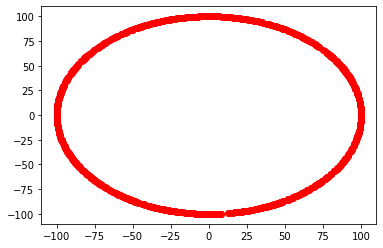

In [7]:
%matplotlib inline

points_3 = generate_array_of_random_points(1000,(0,2*math.pi),(100,100), generate_point_on_circle)
plot3 = Plot([PointsCollection(points_3, color="red")])
plot3.draw()

#### d) 1000 losowych punktów o współrzędnych z przedziału [-1000, 1000] leżących na prostej wyznaczonej przez wektor (a, b), przyjmij a = [-1.0, 0.0], b = [1.0, 0.1]

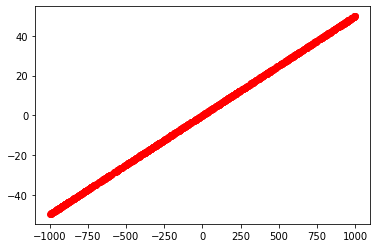

In [8]:
%matplotlib inline

slope, intercept, r_value, p_value, std_err = linregress([-1,1],[0,0.1])
points_4 = generate_array_of_random_points(1000,(slope,intercept),(-1000,1000), generate_point_on_line)
plot4 = Plot([PointsCollection(points_4, color="red")])
plot4.draw()

### Klasyfikacja punktów względem prostej opartej na punktach A, B

#### Funkcje wyliczające wyznaczniki i klasyfikator punktów
Poniżej zdefiniowałem funkcje do klasyfikacji punktu oraz zbioru punktów. Podczas pisania funkcji starałem 
się napisać je tak aby późniejsze rysowanie wykresów wymagało jedynie zmiany jak najmniejszej ilości 
argumentów wywołania. Używając funkcji classify_points() musimy zdefiniować dokładność, czyli `epsilon` oraz 
zbiór punktów klasyfikowanych `points`. Jako opcjonalne argumenty możemy podać: 
* `matrix_generator` - definiuje on funckje która z 3 punktów tworzy macierz, napisałem dwie takie funckje
`generate_matrix_3x3` oraz `generate_matrix_2x2`, tworzą one odpowiednio z podanych punktów macierz 3x3 lub 2x2
* `det_evaluator` - przy pomocy tego argumentu przekazujemy do funkcji, funckję obliczającą wyznacznik, zaimpleemntowałem
dwie funckję liczące wyznacznik `det_ev()` która oblicza wyznacznik zgodnie ze wzorem podanym na zajęciach, oraz
`numpy_det()` która do obliczenia wyznacznika wykorzystuje funckję znajdującą się w bibliotece numpy   

Kolejnymi argumentami są punkty wyznaczające prostą, oraz te pozwalające na zdefiniowanie koloru jaki będzie
przypisany punktom po lewej, prawej i na lini

In [9]:
# [(ax,ay),(bx,by)] = array
def det_ev(array):
    if len(array) == 2:
        return array[0][0]*array[1][1]-array[1][0]*array[0][1]
    if len(array) == 3:
        return (array[0][0]*array[1][1] + array[1][0]*array[2][1] + array[2][0]*array[0][1])-(array[2][0]*array[1][1] + array[0][0]*array[2][1] + array[1][0]*array[0][1])

def numpy_det(array):
    return np.linalg.det(np.array(array))

def generate_matrix_3x3(point, point_a, point_b):
    matrix = [[point_a[0], point_a[1],1], [point_b[0], point_b[1],1], [point[0], point[1],1]]
    return matrix
def generate_matrix_2x2(point, point_a, point_b):
    matrix = [[point_a[0]-point[0], point_a[1]-point[1]], [point_b[0]-point[0], point_b[1]-point[1]]]
    return matrix

def classify_point(point, point_a, point_b, epsilon, matrix_generator, det):
    determinant = det(matrix_generator(point, point_a, point_b))
    if abs(determinant) > epsilon:
        if determinant < 0:
            return -1
        else:
            return 1
    if abs(determinant) < epsilon:
        return 0
    
    
def classify_points(points,epsilon, matrix_generator = generate_matrix_2x2, det_evaluator = det_ev, point_a = (-1.0, 0.0), point_b = (1.0, 0.1), color_left='green', color_right='blue', color_on_line="red"):
    points_left = []
    points_on_line = []
    points_right = []
    for point in points:
        point_class = classify_point(point, point_a, point_b, epsilon, matrix_generator, det_evaluator)
        if point_class > 0:
            points_left.append(point)
        if point_class < 0:
            points_right.append(point)
        if point_class == 0:
            points_on_line.append(point)
    
    return PointsCollection(points_left, color=color_left),PointsCollection(points_on_line, color=color_on_line),PointsCollection(points_right, color=color_right)

#### Wykresy dla pierwszego zbioru punktow:
 
1. epsilon = 0.01
  

a) macierz 2x2

Dla wyznacznika liczonego ze wzoru:

Na lewo:  50035
Na lini:  1
Na prawo:  49964


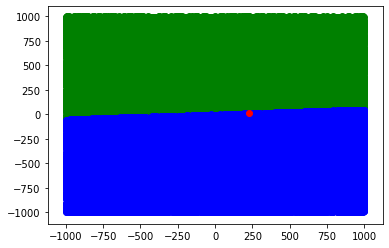

In [10]:
%matplotlib inline

classified_points = classify_points(points_1, 0.01)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [11]:
classified_points = classify_points(points_1, 0.01,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  50035
Na lini:  1
Na prawo:  49964


a) macierz 3x3

Na lewo:  50035
Na lini:  1
Na prawo:  49964


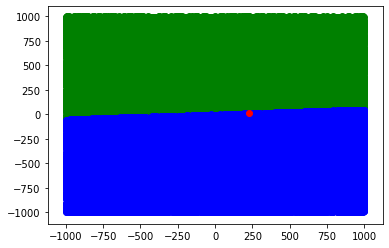

In [12]:
%matplotlib inline

classified_points = classify_points(points_1, 0.01, generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [13]:
classified_points = classify_points(points_1, 0.01,generate_matrix_3x3,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  50035
Na lini:  1
Na prawo:  49964


2. epsilon = 0.1 

a) macierz 2x2

Na lewo:  50032
Na lini:  10
Na prawo:  49958


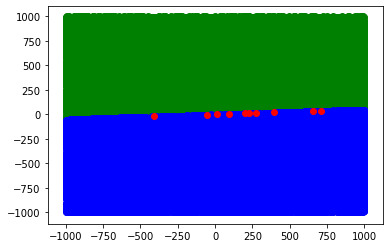

In [14]:
%matplotlib inline

classified_points = classify_points(points_1, 0.1)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [15]:
classified_points = classify_points(points_1, 0.1,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  50032
Na lini:  10
Na prawo:  49958


a) macierz 3x3

Na lewo:  50032
Na lini:  10
Na prawo:  49958


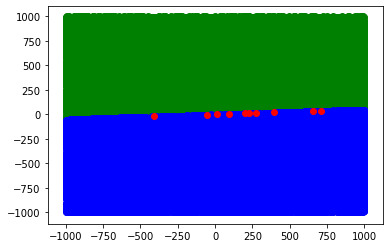

In [16]:
%matplotlib inline

classified_points = classify_points(points_1, 0.1,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [17]:
classified_points = classify_points(points_1, 0.1,generate_matrix_3x3,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  50032
Na lini:  10
Na prawo:  49958


3. epsilon = 1

a) macierz 2x2

Na lewo:  50012
Na lini:  49
Na prawo:  49939


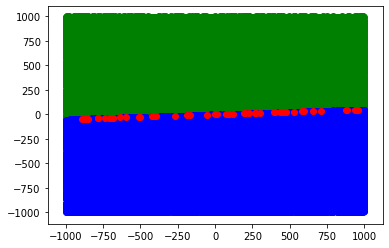

In [18]:
%matplotlib inline

classified_points = classify_points(points_1, 1)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [19]:
classified_points = classify_points(points_1, 1,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  50012
Na lini:  49
Na prawo:  49939


a) macierz 3x3

Na lewo:  50012
Na lini:  49
Na prawo:  49939


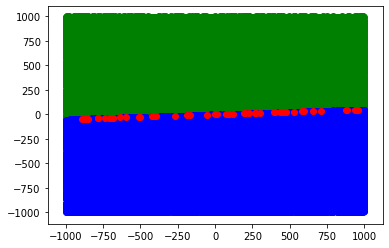

In [20]:
%matplotlib inline

classified_points = classify_points(points_1, 1,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [21]:
classified_points = classify_points(points_1, 1,generate_matrix_3x3,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  50012
Na lini:  49
Na prawo:  49939


4. epsilon = 10

a) macierz 2x2

Na lewo:  49765
Na lini:  528
Na prawo:  49707


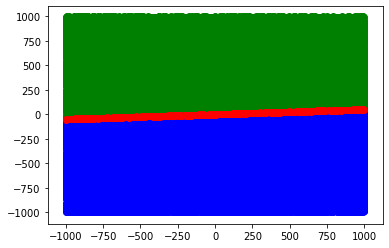

In [22]:
%matplotlib inline

classified_points = classify_points(points_1, 10)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [23]:
classified_points = classify_points(points_1, 10,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  49765
Na lini:  528
Na prawo:  49707


a) macierz 3x3

Na lewo:  49765
Na lini:  528
Na prawo:  49707


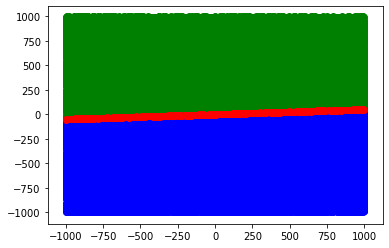

In [24]:
%matplotlib inline

classified_points = classify_points(points_1, 10,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [25]:
classified_points = classify_points(points_1, 10,generate_matrix_3x3,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  49765
Na lini:  528
Na prawo:  49707


#### Wykres dla drugiego zbioru punktow

1. epsilon = 0.1 

a) macierz 2x2

Na lewo:  50159
Na lini:  9
Na prawo:  49832


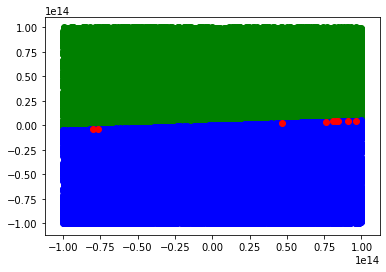

In [26]:
%matplotlib inline

classified_points = classify_points(points_2, 0.1)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [27]:
classified_points = classify_points(points_2, 0.1,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  50163
Na lini:  0
Na prawo:  49837


b) macierz 3x3

Na lewo:  50163
Na lini:  0
Na prawo:  49837


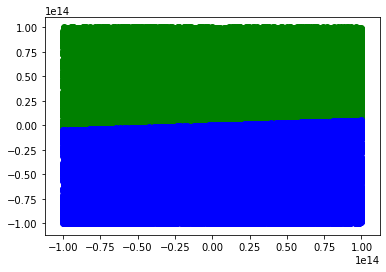

In [28]:
%matplotlib inline

classified_points = classify_points(points_2, 0.1,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [29]:
classified_points = classify_points(points_2, 0.1,generate_matrix_3x3,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  50163
Na lini:  0
Na prawo:  49837


2. epsilon = 10^5

a) macierz 2x2

Na lewo:  50159
Na lini:  9
Na prawo:  49832


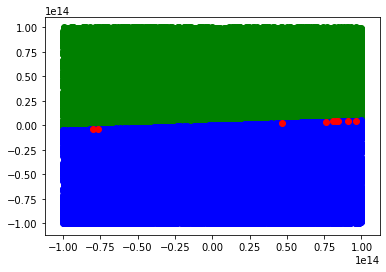

In [30]:
%matplotlib inline

classified_points = classify_points(points_2, math.pow(10,5))
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [31]:
classified_points = classify_points(points_2, math.pow(10,5),det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  50163
Na lini:  0
Na prawo:  49837


b) macierz 3x3

Na lewo:  50163
Na lini:  0
Na prawo:  49837


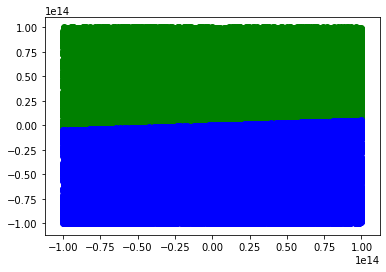

In [32]:
%matplotlib inline

classified_points = classify_points(points_2, math.pow(10,5),generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [33]:
classified_points = classify_points(points_2,math.pow(10,5),generate_matrix_3x3,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  50163
Na lini:  0
Na prawo:  49837


3. epsilon = 10^12 

a) macierz 2x2

Na lewo:  49913
Na lini:  512
Na prawo:  49575


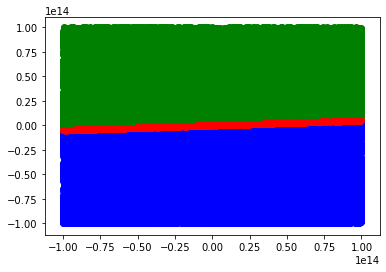

In [34]:
%matplotlib inline

classified_points = classify_points(points_2, math.pow(10,12))
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [35]:
classified_points = classify_points(points_2, math.pow(10,12),det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  49914
Na lini:  510
Na prawo:  49576


b) macierz 3x3

Na lewo:  49916
Na lini:  510
Na prawo:  49574


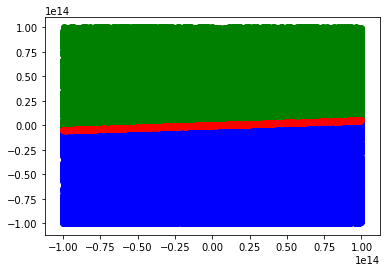

In [36]:
%matplotlib inline

classified_points = classify_points(points_2, math.pow(10,12),generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [37]:
classified_points = classify_points(points_2,math.pow(10,12),generate_matrix_3x3, det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  49916
Na lini:  510
Na prawo:  49574


#### Wykres dla  zbioru punktow na okregu

1. epsilon = 0.1 

a) macierz 2x2

Na lewo:  501
Na lini:  1
Na prawo:  498


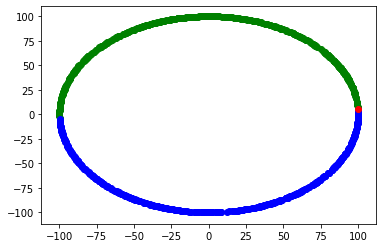

In [38]:
%matplotlib inline

classified_points = classify_points(points_3, 0.1)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [39]:
classified_points = classify_points(points_3, 0.1,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  501
Na lini:  1
Na prawo:  498


b) macierz 3x3

Na lewo:  501
Na lini:  1
Na prawo:  498


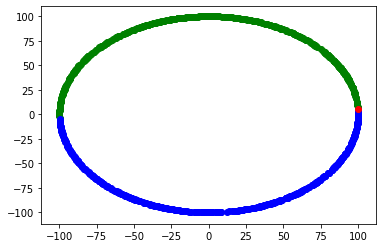

In [40]:
%matplotlib inline

classified_points = classify_points(points_3, 0.1,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [41]:
classified_points = classify_points(points_3,0.1,generate_matrix_3x3,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  501
Na lini:  1
Na prawo:  498


2. epsilon = 5

a) macierz 2x2

Na lewo:  495
Na lini:  12
Na prawo:  493


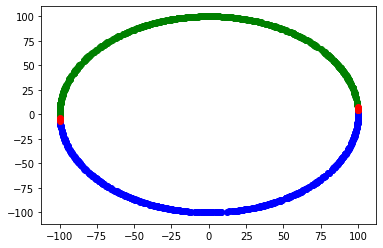

In [42]:
%matplotlib inline

classified_points = classify_points(points_3, 5)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [43]:
classified_points = classify_points(points_2, 5,det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  50163
Na lini:  0
Na prawo:  49837


b) macierz 3x3

Na lewo:  495
Na lini:  12
Na prawo:  493


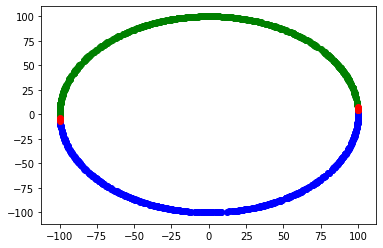

In [44]:
%matplotlib inline

classified_points = classify_points(points_3, 5,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [45]:
classified_points = classify_points(points_3,5,generate_matrix_3x3, det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  495
Na lini:  12
Na prawo:  493


2. epsilon = 10

a) macierz 2x2

Na lewo:  490
Na lini:  27
Na prawo:  483


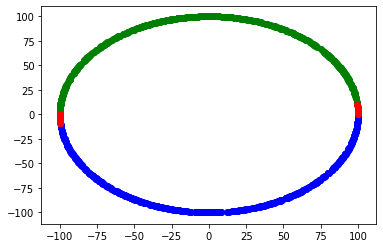

In [46]:
%matplotlib inline

classified_points = classify_points(points_3, 10)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [47]:
classified_points = classify_points(points_3, 10, det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  490
Na lini:  27
Na prawo:  483


b) macierz 3x3

Na lewo:  490
Na lini:  27
Na prawo:  483


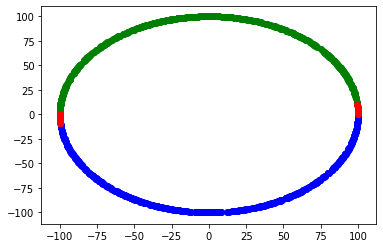

In [48]:
%matplotlib inline

classified_points = classify_points(points_3, 10,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [49]:
classified_points = classify_points(points_3,10,generate_matrix_3x3, det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  490
Na lini:  27
Na prawo:  483


#### Wykres dla  zbioru punktow na prostej

1. epsilon = 10^(-5)

a) macierz 2x2

Na lewo:  0
Na lini:  1000
Na prawo:  0


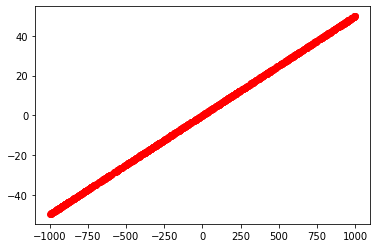

In [50]:
%matplotlib inline

classified_points = classify_points(points_4, 0.00001)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [51]:
classified_points = classify_points(points_4,0.00001, det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  0
Na lini:  1000
Na prawo:  0


b) macierz 3x3

Na lewo:  0
Na lini:  1000
Na prawo:  0


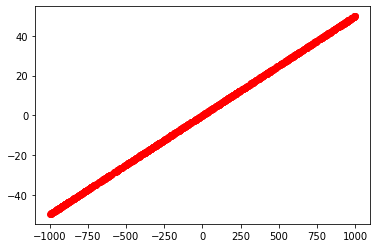

In [52]:
%matplotlib inline

classified_points = classify_points(points_4, 0.00001,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [53]:
classified_points = classify_points(points_4,0.00001,generate_matrix_3x3, det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  0
Na lini:  1000
Na prawo:  0


2. epsilon = 10^(-12)

a) macierz 2x2

Na lewo:  82
Na lini:  842
Na prawo:  76


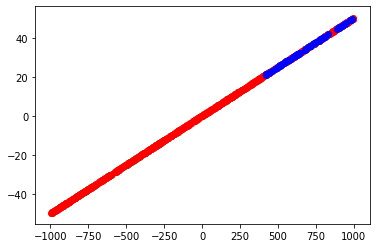

In [54]:
%matplotlib inline

classified_points = classify_points(points_4, 0.000000000001)
plotX = Plot([classified_points[0],classified_points[1],classified_points[2]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [55]:
classified_points = classify_points(points_4,0.000000000001, det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  134
Na lini:  727
Na prawo:  139


b) macierz 3x3

Na lewo:  0
Na lini:  1000
Na prawo:  0


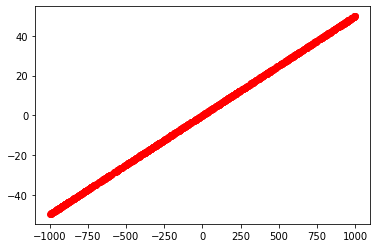

In [56]:
%matplotlib inline

classified_points = classify_points(points_4, 0.000000000001,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[1],classified_points[2]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [57]:
classified_points = classify_points(points_4,0.000000000001,generate_matrix_3x3, det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  0
Na lini:  1000
Na prawo:  0


2. epsilon = 10^(-15)

a) macierz 2x2

Na lewo:  162
Na lini:  712
Na prawo:  126


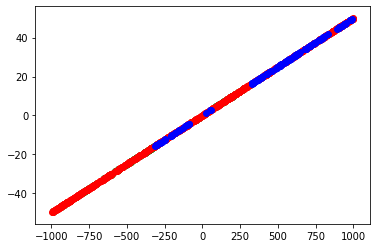

In [58]:
%matplotlib inline

classified_points = classify_points(points_4, 0.000000000000001)
plotX = Plot([classified_points[0],classified_points[1],classified_points[2]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [59]:
classified_points = classify_points(points_4,0.000000000000001, det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  496
Na lini:  28
Na prawo:  476


b) macierz 3x3

Na lewo:  176
Na lini:  454
Na prawo:  370


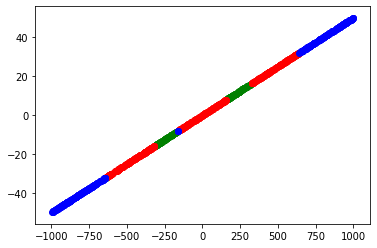

In [60]:
%matplotlib inline

classified_points = classify_points(points_4, 0.000000000000001,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[1],classified_points[2]])
plotX.draw()

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [61]:
classified_points = classify_points(points_4,0.000000000000001,generate_matrix_3x3, det_evaluator=numpy_det)

print("Na lewo: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Na prawo: ", len(classified_points[2].points))

Na lewo:  363
Na lini:  240
Na prawo:  397
